# Building and running a preprocessing pipeline

In this example, an image processing pipeline is created and then executed in a manner that maximizes throughput.

In [2]:
from PIL import Image, ImageOps
import seqtools

In [3]:
! [ -f owl.jpg ] || curl -s "https://cdn.pixabay.com/photo/2017/04/07/01/05/owl-2209827_640.jpg" -o owl.jpg
! [ -f rooster.jpg ] || curl -s "https://cdn.pixabay.com/photo/2018/08/26/14/05/hahn-3632299_640.jpg" -o rooster.jpg
! [ -f duck.jpg ] || curl -s "https://cdn.pixabay.com/photo/2018/09/02/10/03/violet-duck-3648415_640.jpg" -o duck.jpg
! [ -f bird.jpg ] || curl -s "https://cdn.pixabay.com/photo/2018/08/21/05/15/tit-3620632_640.jpg" -o bird.jpg
! [ -f dog.jpg ] || curl -s "https://cdn.pixabay.com/photo/2018/09/04/18/07/pug-3654360_640.jpg" -o dog.jpg
! [ -f hedgehog.jpg ] || curl -s "https://cdn.pixabay.com/photo/2018/09/04/18/52/hedgehog-3654434_640.jpg" -o hedgehog.jpg

## Initial data loading

SeqTools works with list-like indexable objects, so the first step is to create one that maps to our sample files.

In [4]:
labels = ['owl', 'rooster', 'duck', 'bird', 'dog', 'hedgehog']
# We artificially increase the size of the dataset for the example
labels = [labels[i % len(labels)] for i in range(200)]

image_files = [l + '.jpg' for l in labels]

Then this object will undergo a series of transformations.

First, let's load the full resolution images. If lazy evaluation was not used this would use a lot of memory but not with SeqTools.

In [5]:
raw_images = seqtools.smap(Image.open, image_files)

We can verify the result for one sample, this will trigger the loading and return it:

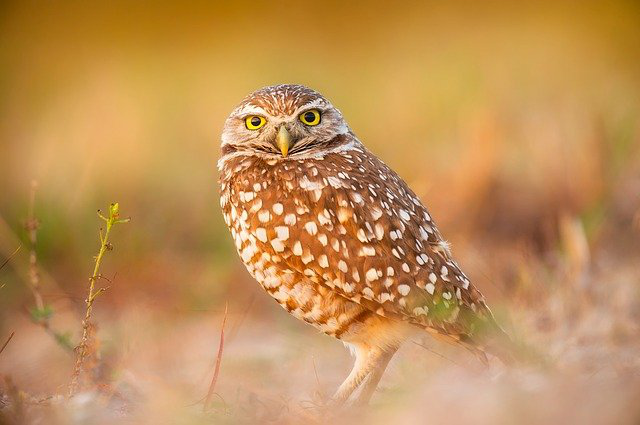

In [6]:
raw_images[0]

##  Mapping transformations

As a first preprocessing stage, we can normalize the size:

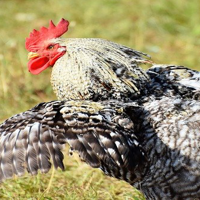

In [7]:
def normalize_size(im):
    w, h = im.size
    left_crop = w // 2 - h // 2
    return im.resize((200, 200), box=(left_crop, 1, h, h))

small_images = seqtools.smap(normalize_size, raw_images)

small_images[1]

then apply a few common preprocessing steps:

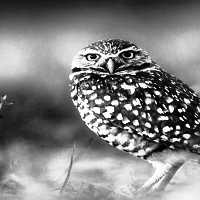

In [8]:
contrasted = seqtools.smap(ImageOps.autocontrast, small_images)
equalized = seqtools.smap(ImageOps.equalize, contrasted)
grayscale = seqtools.smap(ImageOps.grayscale, equalized)

grayscale[0]

That preprocessing seems a bit over the top... let's check where it went wrong:

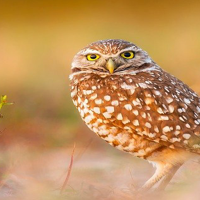

In [9]:
contrasted[0]

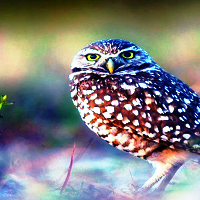

In [10]:
equalized[0]

Note: For each image above, computations were only run to produce the requested item, eventhough we are manipulating the whole dataset as a single object.

We find here that equalization is inappropriate and autocontrast is too weak, let's fix this.

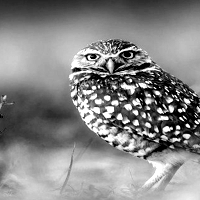

In [11]:
grayscale = seqtools.smap(ImageOps.grayscale, small_images)
contrasted = seqtools.smap(lambda im: ImageOps.autocontrast(im, cutoff=3), grayscale)

contrasted[0]

## Combining datasets

Then we want to augment the dataset with flipped versions of the images:

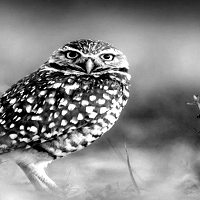

In [12]:
# Generate flipped versions of the images
flipped = seqtools.smap(ImageOps.mirror, contrasted)

# Combine with the original dataset
augmented_dataset = seqtools.concatenate([contrasted, flipped])

augmented_dataset[200]

## Evaluation

Once satisfied with our preprocessing pipeline, evaluating all values is simply done by iterating over the elements or forcing the conversion to a list:

In [15]:
%time computed_values = list(augmented_dataset);

CPU times: user 5.95 s, sys: 79.3 ms, total: 6.03 s
Wall time: 6.14 s


This above evaluation is a bit slow, probably due to the IO operations when loading the images from the hard drive. Maybe using multiple threads could help keep the CPU busy?

In [14]:
fast_dataset = seqtools.prefetch(augmented_dataset, max_buffered=10, nworkers=2)
%time computed_values = list(fast_dataset)

CPU times: user 6.94 s, sys: 100 ms, total: 7.04 s
Wall time: 3.68 s


The CPU time is the same (plus some threading overhead), but wall time is cut down because image processing continues while other files are being loaded.

However, we can spare more IO and computations by not reading the images a second time to generate augmented versions.

To do so, let's simply add some cache over the preprocessed image that will be used as-is or augmented.
Because the cache can only contain so-many files, we make sure to process the normal and augmented variant consecutively so that the input is still available in the cache.
Practically, this is done by interleaving the regular and flipped dataset.

In [16]:
contrasted = seqtools.add_cache(contrasted, cache_size=10)
flipped = seqtools.smap(lambda im: (im, ImageOps.mirror(im)), contrasted)
augmented_dataset = seqtools.interleave(contrasted, flipped)
fast_dataset = seqtools.prefetch(augmented_dataset, max_buffered=10, nworkers=2)

Note: concatenation would be inappropriate to replace unbatching here. Indeed, Concatenation initially checks the length of each sequences (in this case each pair of images) to join, which amounts to evaluating all elements.

In [17]:
%time computed_values = list(fast_dataset)

CPU times: user 3.17 s, sys: 59.6 ms, total: 3.23 s
Wall time: 3.28 s


CPU time is now cut by half, leaving more room for other processes.

## Going further

SeqTools facilitates the manipulation of sequences and reduces the boilerplate from using multi-threading or multi-processing.
However, users must remain conscious of the mechanic under the hood to avoid pitfalls.
Here are a few points to keep in mind while programming with this library:

- Avoid spurious computations when reading the same element multiple times, maybe use cache.
- Check for thread/process under-utilization, avoid having threads waiting for each other or doing redundant work.
- Multi-processing has limitations: communication over-head, no shared cache between processes...
- Threading has limitations: no more than one thread can execute python code at any given time, concurrency is mostly limited to system IO operations.